<a href="https://colab.research.google.com/github/Riyachauhan11/Travel-Itinerary-Planner/blob/main/Travel_Itinerary_Planner_MultiAI_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Key Components



1.   **StateGraph**: The core of our application, defining the flow of our Travel Planner.
2.   **PlannerState**: A custom type representing the state of our planning process.
3. **Node** **Functions**: Individual steps in our planning process (input_city, input_interests, create_itinerary).
4. **LLM** **Integration**: Utilizing a language model to generate the final itinerary.







In [ ]:
!pip install langchain langchain_core langchain_groq langchain_community langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.4/151.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00


In [ ]:
import os
# for creating Planner State
from typing import TypedDict, Annotated, List
# for creating StateGraph
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display

Define Agent

In [ ]:
class PlannerState(TypedDict):
  messages : Annotated[List[HumanMessage | AIMessage],"the messages in the conversation"]
  city: str
  interests: List[str]
  itinerary: str

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature = 0,
    groq_api_key = "",
    model_name = "llama-3.3-70b-versatile"
)

In [ ]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

Define agent Functions

In [ ]:
# human input
def input_city(state: PlannerState) -> PlannerState:
  print("Please enter the city you want to visit for your day trip: ")
  user_message = input("Your input: ")
  return {
      **state,
      "city": user_message,
      "messages": state["messages"] + [HumanMessage(content=user_message)]
  }

def input_interests(state: PlannerState) -> PlannerState:
  print(f"Please enter your interests for the trip to : {state['city']} (comma-separated): ")
  user_message = input("Your input: ")
  return {
      **state,
      "interests": [interest.strip() for interest in user_message.split(",")],
      "messages": state["messages"] + [HumanMessage(content=user_message)]
  }
# AI Response
def create_itinerary(state: PlannerState) -> PlannerState:
  print(f"Creating an itinerary for {state['city']} based on interests : {', '.join(state['interests'])}")
  response = llm.invoke(itinerary_prompt.format_messages(city=state['city'],interests = ', '.join(state['interests'])))
  print("\nFinal Itinerary: ")
  print(response.content)
  return {
      **state,
      "messages": state["messages"] + [AIMessage(content=response.content)],
      "itinerary": response.content
  }

Create and compile the Graph


In [ ]:
workflow = StateGraph(PlannerState)

workflow.add_node("input city",input_city)
workflow.add_node("input interests",input_interests)
workflow.add_node("create itinerary",create_itinerary)

workflow.set_entry_point("input city")

workflow.add_edge("input city","input interests")
workflow.add_edge("input interests","create itinerary")
workflow.add_edge("create itinerary",END)

app = workflow.compile()

Display the Graph Structure

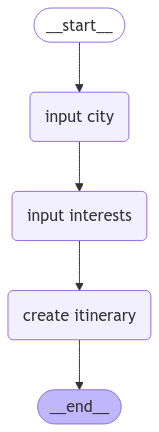

In [ ]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)

Define the function that runs the graph

In [ ]:
def travel_planner(user_request: str):
  print(f"Initial Request: {user_request}\n")
  state = {
      "messages": [HumanMessage(content = user_request)],
      "city":"",
      "interests":[],
      "itinerary":""
      }
  for output in app.stream(state):
    pass


In [ ]:
user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip: 
Your input: Nashik
Please enter your interests for the trip to : Nashik (comma-separated): 
Your input: Trimbakeshwar,  Brahmagiri
Creating an itinerary for Nashik based on interests : Trimbakeshwar, Brahmagiri

Final Itinerary: 
Here's a brief day trip itinerary for Nashik based on your interests:

* 8:00 AM: Start the day with a visit to Trimbakeshwar Temple, one of the 12 Jyotirlingas in India
* 10:00 AM: Explore the Brahmagiri Hill, the source of the Godavari River
* 12:30 PM: Take a break for lunch at a local restaurant
* 2:00 PM: Visit the Gangadwar Temple and take a stroll along the Godavari River
* 4:00 PM: Return to Nashik city, stopping at any other points of interest along the way

This itinerary provides a mix of spiritual, natural, and cultural experiences, and can be adjusted based on your personal preferences and time constraints.


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

# Define the LLM
llm = ChatGroq(
    temperature=0,
    groq_api_key="",
    model_name="llama-3.3-70b-versatile"
)

# Define the itinerary prompt
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

def input_city(city: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "city": city,
        "messages": state['messages'] + [HumanMessage(content=city)],
    }

def input_interests(interests: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "interests": [interest.strip() for interest in interests.split(',')],
        "messages": state['messages'] + [HumanMessage(content=interests)],
    }

def create_itinerary(state: PlannerState) -> str:
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests'])))
    state["itinerary"] = response.content
    state["messages"] += [AIMessage(content=response.content)]
    return response.content

# Define the Gradio application
def travel_planner(city: str, interests: str):
    # Initialize state
    state = {
        "messages": [],
        "city": "",
        "interests": [],
        "itinerary": "",
    }

    # Process the city and interests inputs
    state = input_city(city, state)
    state = input_interests(interests, state)

    # Generate the itinerary
    itinerary = create_itinerary(state)

    return itinerary

# Build the Gradio interface
interface = gr.Interface(
    fn=travel_planner,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=[
        gr.Textbox(label="Enter the city for your day trip"),
        gr.Textbox(label="Enter your interests (comma-separated)"),
    ],
    outputs=gr.Textbox(label="Generated Itinerary"),
    title="Travel Itinerary Planner",
    description="Enter a city and your interests to generate a personalized day trip itinerary."
)

# Launch the Gradio application
interface.launch()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


themes%2Ftheme_schema%400.0.1.json:   0%|          | 0.00/12.6k [00:00<?, ?B/s]

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c01046acd99042e830.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
